In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from os import environ
import tensorflow as tf
from tensorflow import keras
from dotenv import load_dotenv
from app import yahoo_finance, CoinMarketCap, GoogleTrends, Alphavantage
import joblib

from keras.models import Sequential, Model
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, BatchNormalization, ReLU, MaxPooling2D
from keras.layers import Activation, Masking 
from keras.layers import Dropout, PReLU
from keras.layers import Conv1D, Input, SpatialDropout2D
from keras.layers import MaxPooling1D, Reshape, ConvLSTM2D, Conv2D
from keras.layers import Flatten, RepeatVector
from keras.layers import TimeDistributed, Permute, Concatenate, Multiply, Lambda
from keras.constraints import maxnorm
from keras.optimizers import SGD, Nadam, Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, model_from_json

import plotly.express as px

In [5]:
def build_dset(n_coins: int, gtrends: bool = False):

    # Get top 10 coins by mktcap
    load_dotenv()
    mktcap_key = environ.get('COIN_MKTCAP_KEY')
    cmc = CoinMarketCap(mktcap_key)
    coins_df = cmc.get_top_coins(n_coins)

    # Daily US yield curve to account for interest rate (inflation) effect
    yield_curve = ['^FVX', '^TNX', '^TYX']
    ir_dfs = []
    for ir in yield_curve:
        min_date = coins_df['first_historical_data'].min()
        status, ir_data = yahoo_finance.market_value(ir, hist=min_date, interval='1d')
        ir_data.rename(columns={'Close': ir[1:]}, inplace=True)
        ir_close =  ir_data[ir[1:]]
        ir_dfs.append(ir_close)
    us_treasury = pd.concat(ir_dfs, axis=1)

    # Get daily market data for top 10 coins
    data_dict = {}
    for idx, coin in coins_df.iterrows():
        coin_name = coin['name']
        ticker = coin['symbol'] + '-USD'
        start = coin['first_historical_data']

        # Get daily market data from yahoo
        status, data = yahoo_finance.market_value(ticker, hist=start, interval='1d')
        print(coin_name, coin['days_history'])
        print(data.shape)
        # Add yield curve data
        data = data.merge(us_treasury, how='left', left_index=True, right_index=True)
        xcols = ['High', 'Low', 'Volume'] + [s[1:] for s in yield_curve]

        if gtrends:
            gt = GoogleTrends()
            # Get daily google trend data
            start_str = dt.datetime.strftime(start, r'%Y-%m-%d')
            end_str = dt.datetime.strftime(dt.datetime.today(), r'%Y-%m-%d')
            gtrend = gt.get_daily_trend_df([coin_name], start_date=start_str, end_date=end_str)
            data = data.merge(gtrend, how='left', left_index=True, right_index=True)
            data = data.rename(columns={coin_name: 'Google_Trend'})
            xcols = ['High', 'Low', 'Volume'] + [s[1:] for s in yield_curve] + ['Google_Trend']

        data = data.fillna(method='ffill')[xcols + ['Close']]
        data_dict[coin_name] = data
        
    return data_dict

In [6]:
dsets = build_dset(n_coins=10, gtrends=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Bitcoin 3341
(2836, 6)
[*********************100%***********************]  1 of 1 completed
Ethereum 2510
(1687, 6)
[*********************100%***********************]  1 of 1 completed
Tether 2673
(1687, 6)
[*********************100%***********************]  1 of 1 completed
XRP 3243
(1687, 6)
[*********************100%***********************]  1 of 1 completed
Dogecoin 3110
(1687, 6)
[*********************100%***********************]  1 of 1 completed
Litecoin 3341
(2836, 6)
[*********************100%***********************]  1 of 1 completed
Stellar 2877
(1687, 6)
[*********************100%***********************]  1 of 1 completed
Monero 2954
(1687, 6)
[*********************100%***********************]  1 of 1 c

# Data Pre-processing

## Feature Selection
Since we find that some features are highly correlated to each other, we reduce the number of features to 3: the cryptocurrency daily close, traded volume, and the only one of the treasure bond yield maturities available (FVX, TNX, TYX). 
We decided to leave out the daily high and low price because they have a correlation of 0.99 with the daily close, which suggests that using the daily close as predictor int he autoregressive part of the model is enough and they would not add valuable information. 
As for the interest rate, we notice that the 5, 10 and 30 year maturities of US treasury bonds are also highly correlated. Different cryptocurrencies are affected by different maturities of the risk free rate. We noticed that, depending on the cryptocurrency, one of the maturities will exhibit a higher correlation with the price. This is why we stablish a simple feature selection rule to include only the most relevant bond yield.

In [7]:
dsets['Bitcoin'].corr()

,High,Low,Volume,FVX,TNX,TYX,Close
High,1.000000,0.999043,0.727761,-0.238843,-0.276585,-0.400688,0.999476
Low,0.999043,1.000000,0.715643,-0.236547,-0.276349,-0.402079,0.999390
Volume,0.727761,0.715643,1.000000,-0.430589,-0.491193,-0.585390,0.722598
FVX,-0.238843,-0.236547,-0.430589,1.000000,0.963248,0.846202,-0.239308
TNX,-0.276585,-0.276349,-0.491193,0.963248,1.000000,0.951731,-0.277752
TYX,-0.400688,-0.402079,-0.585390,0.846202,0.951731,1.000000,-0.402230
Close,0.999476,0.999390,0.722598,-0.239308,-0.277752,-0.402230,1.000000


In [8]:
def select_features(data_dict):
    """
    Simple feature selection rule for each coin.
    Keep the volume and select the US treasury bond maturity with the highest correlation to the target.
    """

    for coin, dset in data_dict.items():
        selected_features = ['Volume']
        corr = dsets[coin].corr()
        yield_curve = ['FVX', 'TNX', 'TYX']
        corr_yield = np.abs(corr[yield_curve])
        ir_index = corr_yield.loc['Close', :].argmax()
        selected_features += [yield_curve[ir_index]]
        data_dict[coin] = dset[selected_features + ['Close']]

    return data_dict

In [9]:
dsets = select_features(dsets)

## Data Structure

In [10]:
def series_to_supervised(df, n_in=1, n_out=1, target_idx=-1, 
                         dropnan=True, min_input=None):
    
    df = df.copy(deep=True)
    n_in = int(n_in)
    min_input = int(min_input)
    target = df.columns[target_idx]
    df[target + '_t'] = df[target]
    n_vars = df.shape[1] - 1
    
    vars = list(df.columns)
    vars.remove(target)
    cols, names = list(), list()
    # input sequences (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.iloc[:,:target_idx].shift(i))
      names += [(var + '(t-%d)' % i) for var in vars]
    # current features (t)
    cols.append(df)
    names += [(var + '(t)') for var in vars]
    names += [target + '(t)']
     # forecast sequence (t, t+1, ... t+n)
    for i in range(1, n_out):
      cols.append(df[target].shift(-i))    
      names += [target + '(t+%d)' % i]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan and min_input:
      agg.dropna(inplace=True, thresh=n_vars*(min_input+1))
    agg.drop(columns=[(var + '(t)') for var in vars], inplace=True)
    return agg

def prep_data(df, timesteps, test_days=365, scaler=None):

    reframed = series_to_supervised(df, n_in=timesteps, min_input=timesteps)
    seqs = reframed.values 

    if not scaler:
        scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_seqs = scaler.fit_transform(seqs)

    X = scaled_seqs[:,:-1].reshape((seqs.shape[0], 
                            timesteps, 
                            int(seqs.shape[1]/timesteps)
                            ))
    y = scaled_seqs[:, -1]

    X_train, X_test = X[:-test_days, :, :], X[-test_days:, :, :]
    y_train, y_test = y[:-test_days], y[-test_days:]

    test_dates = df.iloc[-test_days:, :].index
    
    return X_train, y_train, X_test, y_test, scaler, test_dates

In [11]:
timesteps = 60
prep_dsets = {
    coin: prep_data(df, timesteps) for coin, df in dsets.items()
}

In [12]:
X_train, y_train, X_test, y_test, scaler, test_dates = prep_dsets['Bitcoin']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2411, 60, 3) (2411,) (365, 60, 3) (365,)


## LSTM NN Architectures

In [13]:
# Functions to define NN with different architectures

def build_LSTM(in_shape, 
               num_rnns=1, 
               dim_rnn=128,
               dense_units=100,
               num_ysteps=1, 
               lr=1e-3,
               decay=6e-8,
               drop=False,
               drop_rate=0.2,
               masking=False,
               mv=-np.inf,
               model_name='LSTM'
               ):
  
  """Builds a classifier with LSTM layers with the given parameters

     Parameters:
     - in_shape: the constant shape of the input data X
     - num_rnns: how many lstm layers to add
     - dim_rnns: the number of units for each lstm layer
     - dense_units: number of units for the dense layer that goes after lstms
     - num_ysteps: how many time steps of the target to predict
     - drop: would you like to use dropout layers to prevent overfitting?
     - **masking: do not set this parameter to True because you cannot
                  manipulate the data to use a masking value.
     - extra Neural Network training parameters...

     Returns a keras model for classification that has not yet been trained"""

  # sequence input
  in_seq = Input(shape=in_shape, name='sequential_input')
  
  if masking:
    # tell rnns to ignore masked-padded timesteps
    x = Masking(mask_value=mv)(in_seq)
  else:
    x = in_seq
  
  lstm_out = LSTM(dim_rnn, activation='relu',
                  return_sequences=True)(x)
  if drop:
    lstm_out = Dropout(drop_rate)(lstm_out)
  
  rnn_layers = 1
  while rnn_layers < num_rnns:
    rnn_layers +=1
    rs = not (rnn_layers == num_rnns)
    lstm_out = LSTM(dim_rnn, activation='relu',
                    return_sequences=rs)(lstm_out)
  if drop:
    lstm_out = Dropout(drop_rate)(lstm_out)

  xx = Dense(dense_units, activation='relu')(lstm_out)
  pred_out = Dense(num_ysteps, activation='relu')(xx)

  # Define Model
  lags = in_shape[0]
  features = in_shape[1]
  predictor = Model(in_seq, pred_out, name=model_name + '_' + str(lags) + '_lags_' + str(features) + '_fts')
  # compile model
  opt = Adam(lr=lr, decay=decay)
  predictor.compile(loss='mse', 
                     optimizer=opt, metrics=['mse'])
  predictor.summary()
  
  return predictor


def build_BLSTM(in_shape, 
                num_rnns=1, 
                dim_rnn=128,
                dense_units=100, 
                num_ysteps=1,
                lr=1e-3, 
                decay=6e-8,
                drop=False,
                drop_rate=0.2,
                masking=False,
                mv=-np.inf,
                model_name='Bidirectional_LSTM'
                ):

  """Builds classifier with Bidirectional LSTM layers from the given parameters

    Parameters:
    - in_shape: the constant shape of the input data X
    - num_rnns: how many lstm layers to add
    - dim_rnns: the number of units for each lstm layer
    - dense_units: number of units for the dense layer that goes after lstms
    - num_ysteps: how many timesteps of the target to predict
    - drop: would you like to use dropout layers to prevent overfitting?
    - extra Neural Network training parameters...

    Returns a keras model for classification that has not yet been trained"""

  # sequence input
  in_seq = Input(shape=in_shape, name='sequential_input')

  if masking:
    # tell rnns to ignore masked-padded timesteps
    x = Masking(mask_value=mv)(in_seq)
  else:
    x = in_seq
  lstm_out = Bidirectional(LSTM(dim_rnn, activation='relu',
                                return_sequences=True))(x)
  rnn_layers = 1
  while rnn_layers < num_rnns:
    rnn_layers +=1
    rs = not (rnn_layers == num_rnns)
    lstm_out = Bidirectional(LSTM(dim_rnn, activation='relu',
                                  return_sequences=rs))(lstm_out)
  if drop:
    lstm_out = Dropout(drop_rate)(lstm_out)

  xx = Dense(dense_units, activation='relu')(lstm_out)
  pred_out = Dense(num_ysteps, activation='relu')(xx)

  # Define Model
  lags = in_shape[0]
  features = in_shape[1]
  predictor = Model(in_seq, pred_out, name=model_name + '_' + str(lags) + '_lags_' + str(features) + '_fts')
  # compile model
  opt = Adam(lr=lr, decay=decay)
  predictor.compile(loss='mse', 
                     optimizer=opt, metrics=['mse'])
  predictor.summary()

  return predictor


def build_AttentiveBLSTM(in_shape,    # (num_timesteps, num_features)
                         num_rnns=1, 
                         dim_rnn=64, 
                         num_ysteps=1, 
                         lr=1e-3, 
                         decay=6e-8,
                         drop=False,
                         drop_rate=0.2,
                         masking=False,
                         mv=-np.inf,
                         model_name='Attentive_BLSTM'
                         ):
  
  """Builds classifier with Bidirectional LSTM layers and Attention 
      implementation from the given parameters

     Parameters:
     - in_shape: Tuple (num_timesteps, num_features)
                 the constant shape of each sample in the input data X
     - num_rnns: how many lstm layers to add
     - dim_rnns: the number of units for each lstm layer
     - dense_units: number of units for the dense layer that goes after lstms
     - num_ysteps: how many timesteps of the target to predict
     - drop: would you like to use dropout layers to prevent overfitting?
     - extra Neural Network training parameters...
     Returns a keras model for classification that has not yet been trained"""
  
  # sequence input
  in_seq = Input(shape=in_shape, name='sequential_input')
  
  if masking:
    # tell rnns to ignore masked-padded timesteps
    x = Masking(mask_value=mv)(in_seq)
  else:
    x = in_seq
  lstm_out = Bidirectional(LSTM(dim_rnn, return_sequences=True,input_shape=in_shape))(x)
  rnn_layers = 1
  if drop:
    lstm_out = Dropout(drop_rate)(lstm_out)
  while rnn_layers < num_rnns:
    rnn_layers +=1
    lstm_out = Bidirectional(LSTM(dim_rnn, return_sequences=True))(lstm_out)   
  if drop:
    lstm_out = Dropout(drop_rate)(lstm_out)
  # adding attention
  e = Dense(1, activation='tanh')(lstm_out)
  e = Flatten(data_format=None)(e)
  a = Activation('softmax')(e)
  temp = RepeatVector(2*dim_rnn)(a)
  temp = Permute([2, 1])(temp)
  # multiply weights with lstm output
  att_out = Multiply()([lstm_out, temp])
  # attention adjusted output state
  att_out = Lambda(lambda values: K.sum(values, axis=1))(att_out)
  pred_out = Dense(num_ysteps, activation='relu')(att_out)

  # Define Model
  lags = in_shape[0]
  features = in_shape[1]
  predictor = Model(in_seq, pred_out, name=model_name + '_' + str(lags) + '_lags_' + str(features) + '_fts')
  # compile model
  opt = Adam(lr=lr, decay=decay)
  predictor.compile(loss='mse', 
                     optimizer=opt, metrics=['mse'])
  predictor.summary()

  return predictor

# Training

Model: "Bidirectional-LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_input (InputLaye  [(None, 60, 3)]          0         
 r)                                                              
                                                                 
 bidirectional_7 (Bidirectio  (None, 60, 50)           5800      
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 50)               15200     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 100)               5100      
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                

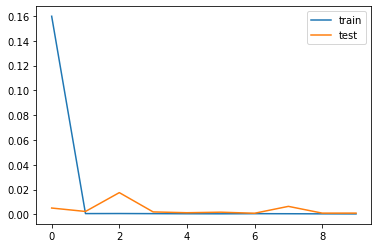

In [43]:
# Prepare the samples
X_train, y_train, X_test, y_test, scaler, test_dates = prep_dsets['Bitcoin']

# Build lstm model
blstm_model = build_BLSTM(
                        in_shape=(X_train.shape[1], X_train.shape[2]),
                        num_rnns=2,
                        dim_rnn=25,
                        dense_units=50,
                        drop=True
                        )

# This EarlyStopping callback stops training once it stops improving
# so that you can set a high number of epochs and let it choose when to stop
monitor = EarlyStopping(monitor='val_loss', 
                        min_delta=1e-3, 
                        patience=5, 
                        verbose=0, 
                        mode='auto', 
                        restore_best_weights=True)

# Train the model
history = blstm_model.fit(
                        X_train, y_train, 
                        validation_data=(X_test, y_test),
                        callbacks=[monitor],
                        verbose=2, 
                        epochs=10,
                        batch_size=1 #X_train.shape[0]
                        )

# visualize training
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

# Prediction and Validation

In [14]:
def save_model(model, path="./models/", coin_ticker='BTC'):
    
    # serialize model
    model_json = model.to_json()
    full_path = path + coin_ticker + '_' + model.name + '.json'
    with open(full_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights
    weights_path = full_path.replace('.json', '.h5')
    model.save_weights(weights_path)


def save_scaler(fitted_scaler, path="./models/", coin_ticker='BTC'):
    
    full_path = path + coin_ticker + '_scaler.gz'
    joblib.dump(fitted_scaler, full_path)


def load_scaler(path="./models/", coin_ticker='BTC'):
    
    full_path = path + coin_ticker + '_scaler.gz'
    my_scaler = joblib.load(full_path)
    return my_scaler


def load_model(path="./models/", coin_ticker='BTC', model_name='blstm'):
    
    # load json and create model
    full_path = path + coin_ticker + '_' + model_name + '.json'
    json_file = open(full_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    weights_path = full_path.replace('.json', '.h5')
    loaded_model.load_weights(weights_path)

    return loaded_model

In [17]:
def get_test_df(model, x_test, y_test, scaler, test_dates):
    
    predicted = model.predict(x_test)
    X_test_2d = X_test.reshape((X_test.shape[0], timesteps * X_test.shape[2]))
    xpred_2d = np.append(X_test_2d, predicted, axis=1)
    pred_y = scaler.inverse_transform(xpred_2d)[:, -1]
    xtrue_2d = np.append(X_test_2d, y_test.reshape(predicted.shape), axis=1)
    true_y = scaler.inverse_transform(xtrue_2d)[:, -1]

    test_df = pd.DataFrame()
    test_df['Observed'] = true_y
    test_df['Predicted'] = pred_y
    test_df.index = test_dates

    return test_df


def plot_model_test(test_df, px_theme='plotly_dark'):

    fig = px.line(test_df, x=test_df.index, y=test_df.columns,
              title=model.name,
              template=px_theme
              )
    fig.update_yaxes(title_text = 'Close Price')
    fig.update_layout(yaxis_tickformat = '$')
    fig.update_traces(hovertemplate='%{y:$,.2f}')
    fig.update_layout(hovermode="x unified")

    fig.update_xaxes(
        title_text = 'Date',
        rangeslider_visible = True
        )
    fig.show()

In [18]:
# This is what we would call in the dashboard
model = load_model()
scaler = load_scaler()
test_df = get_test_df(model, X_test, y_test, scaler, test_dates)
plot_model_test(test_df)

12/12 [==============================] - 1s 15ms/step


# Feature Importance

In [61]:
reframed = series_to_supervised(dsets['Bitcoin'], n_in=60, min_input=60)
feature_names = reframed.iloc[:, :-1].columns
feature_names = list(feature_names)

results = []

oof_preds = model.predict(X_test, verbose=0).squeeze() 
baseline_mae = np.mean(np.abs(oof_preds - y_test))
results.append({'Feature':'BASELINE','Importance':baseline_mae})
np.random.seed(888)
for k in range(60):
    for f in range(3):
        # SHUFFLE LAG k OF FEATURE f
        save_col = X_test[:,k,f].copy()
        np.random.shuffle(X_test[:,k,f])
                
        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        oof_preds = model.predict(X_test, verbose=0).squeeze() 
        mae = np.mean(np.abs(oof_preds - y_test))
        results.append({'Feature':feature_names.pop(0),'Importance':mae})
        X_test[:,k,f] = save_col

results_df = pd.DataFrame(results)

results_df = results_df.sort_values('Importance')

In [66]:
fig = px.bar(
    results_df.query('Importance >= @baseline_mae').iloc[-15:,:], 
    y='Feature', 
    x='Importance', 
    orientation='h', 
    template='plotly_dark',
    title='Feature Importance (MAE Perturbation)'
    )
fig.update_traces(marker_color='rgba(50, 171, 96, 0.6)')
fig.show()

## Bidirectional LSTM with Attention

Model: "Attentive_BLSTM_60_lags_3_fts"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequential_input (InputLayer)  [(None, 60, 3)]      0           []                               
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 60, 128)     34816       ['sequential_input[0][0]']       
 )                                                                                                
                                                                                                  
 dropout_8 (Dropout)            (None, 60, 128)      0           ['bidirectional_8[0][0]']        
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 60, 128)     98816       ['dro

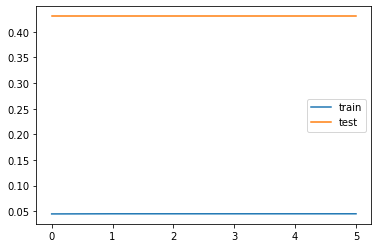

In [27]:
# Prepare the samples
X_train, y_train, X_test, y_test, scaler, test_dates = prep_dsets['Bitcoin']

# Build lstm model
ablstm_model = build_AttentiveBLSTM(
                        in_shape=(X_train.shape[1], X_train.shape[2]),
                        num_rnns=2,
                        dim_rnn=64,
                        drop=True
                        )

# This EarlyStopping callback stops training once it stops improving
# so that you can set a high number of epochs and let it choose when to stop
monitor = EarlyStopping(monitor='val_loss', 
                        min_delta=1e-3, 
                        patience=5, 
                        verbose=0, 
                        mode='auto', 
                        restore_best_weights=True)

# Train the model
history = ablstm_model.fit(
                        X_train, y_train, 
                        validation_data=(X_test, y_test),
                        callbacks=[monitor],
                        verbose=2, 
                        epochs=10,
                        batch_size=1 #X_train.shape[0]
                        )

# visualize training
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

save_model(ablstm_model, coin_ticker='BTC')

In [28]:
ab_test_df = get_test_df(ablstm_model, X_test, y_test, scaler, test_dates)
plot_model_test(ab_test_df)

12/12 [==============================] - 2s 19ms/step
